In [1]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import os
import sys
import glob
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args



/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

In [2]:
# 导入数据

data = pd.read_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/input/final_data_input_important_16869.csv')
# C:/Jiqiang/jh_z/jh_z/model training_pc/final_data_input_important.csv
# /Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important.csv
df= pd.DataFrame(data)
counts = df['label'].value_counts()
num_zeros = counts[0]
num_ones = counts[1]
print("number of zero:",num_zeros)
print("number of one:",num_ones)

df


number of zero: 14402
number of one: 2466


,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
1,1,1.036179,0.173910,0.540058,1452.270984,3.351578,2289.101516,7.397089,1
2,2,1.034249,0.173900,0.540413,1427.899396,3.355286,2170.271564,7.548316,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
4,4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661,1
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [3]:
# 所有特征
all_features = df.iloc[:, 1:-1]
all_features

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351
1,1.036179,0.173910,0.540058,1452.270984,3.351578,2289.101516,7.397089
2,1.034249,0.173900,0.540413,1427.899396,3.355286,2170.271564,7.548316
3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202
4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661
...,...,...,...,...,...,...,...
16863,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090
16864,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834
16865,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009
16866,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220


In [4]:
# 从总数据中抽取1000个1和1000个0作为训练和测试，剩下的作为预测集
# 随机抽取label为0和1的数据各1000个
df1 = pd.concat([df[df['label']==0].sample(n=1000),df[df['label']==1].sample(n=1000)]) # 训练集和测试集
print(df1)

# 删除已经抽取的数据，剩下的放入df2中
df2 = df.drop(df1.index) # 剩下的数据作为预测集
df2


        FID_  average_max_rainfall  average_2hr_rainfall   
2854    2933              1.027032              0.171163  \
9430    9678              1.030391              0.172096   
9127    9370              1.048012              0.161205   
4957    5095              1.017965              0.172177   
3568    3685              0.999342              0.173260   
...      ...                   ...                   ...   
11629  11962              0.985511              0.167060   
8500    8739              0.938219              0.164266   
12959  13351              1.059411              0.168083   
5640    5816              0.985729              0.173944   
2509    2577              1.014294              0.171909   

       average_72hr_rainfall  distance to coast        EV          TWI   
2854                0.541844         641.290973  3.385545  1204.935483  \
9430                0.564704         186.079413  2.539883   120.256997   
9127                0.550393         332.646796  2.711301

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
7,7,1.030442,0.173909,0.541106,1389.506261,3.703773,1914.187620,5.250920,0
10,10,1.052772,0.174059,0.537689,1456.337635,3.918565,2524.349979,5.334451,1
11,11,1.052868,0.174058,0.537678,1459.758586,3.986615,2520.808509,4.588114,0
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [5]:
# 固定训练集、测试集、预测集，将其分别输出到CSV文件中
df1.to_csv('train_test_data.csv', index=False)
df2.to_csv('predict_data.csv', index=False)

In [6]:
# 用df1中的数据划分训练集和测试集，输出到CSV文件中，随后分别为训练集和测试集输入特征进行标准化
from sklearn.model_selection import train_test_split

# 提取最后一列并命名为“y”
Y = df1.iloc[:, -1]
Y.name = 'y'


X_train_orgin, X_test_orgin, Y_train_orgin, Y_test_orgin = train_test_split(df1.drop('label', axis=1), df1['label'], test_size=0.2, random_state=42)

# 输出训练集和测试集
X_train_Y_train = pd.concat([X_train_orgin, Y_train_orgin],axis=1)
X_test_Y_test = pd.concat([X_test_orgin, Y_test_orgin],axis=1)

X_train_Y_train.to_csv('train_data.csv', index=False)
X_test_Y_test.to_csv('test_data.csv', index=False)

# 训练集和测试集的特征标准化
from sklearn.preprocessing import StandardScaler


# 提取除最后一列和第一列单元名以外的所有列并命名为“X”
X_train_orgin_dropFID = X_train_orgin.iloc[:, 1:]
X_test_orgin_dropFID = X_test_orgin.iloc[:, 1:]
X_pred = df2.iloc[:, 1:-1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orgin_dropFID)
X_test_scaled = scaler.transform(X_test_orgin_dropFID)
X_pred_scaled = scaler.transform(X_pred)

# 将标准化后的数据输出到新的数据框中
X_train = pd.DataFrame(X_train_scaled, columns=X_train_orgin_dropFID.columns, index=X_train_orgin_dropFID.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_orgin_dropFID.columns,  index=X_test_orgin_dropFID.index)
X_pred = pd.DataFrame(X_pred_scaled, columns=X_pred.columns, index=X_pred.index)

Y_train = Y_train_orgin
Y_test = Y_test_orgin

In [7]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.432630,0.890960,-1.038326,2.028556,0.860956,1.179620,1.126717
3,0.580180,0.893061,-1.109806,2.243038,0.901934,1.464602,2.102643
7,0.396328,0.891687,-1.019603,2.003427,1.119368,1.032903,-0.563906
10,0.824065,0.914127,-1.204403,2.166318,1.337791,1.791035,-0.501432
11,0.825910,0.914094,-1.204995,2.174656,1.406990,1.786635,-1.059634
...,...,...,...,...,...,...,...
16863,-0.702539,0.875810,-0.095450,-0.679580,-0.133438,-0.108165,-0.343891
16864,-0.719087,0.870297,-0.100513,-0.647444,-0.029992,-0.072902,1.062009
16865,-0.667005,0.883984,-0.079468,-0.791647,-0.460202,-0.239412,0.476518
16866,-0.636365,0.889980,-0.064066,-0.836215,-0.440026,-0.368419,0.231358


In [8]:
X_pred_scaled

array([[ 0.43262984,  0.89095958, -1.03832577, ...,  0.86095628,
         1.17961961,  1.12671748],
       [ 0.58018009,  0.89306122, -1.10980644, ...,  0.90193384,
         1.46460241,  2.10264261],
       [ 0.39632796,  0.89168744, -1.01960347, ...,  1.11936842,
         1.03290275, -0.56390643],
       ...,
       [-0.66700489,  0.8839836 , -0.07946804, ..., -0.46020222,
        -0.23941168,  0.47651771],
       [-0.63636539,  0.88998038, -0.06406555, ..., -0.44002621,
        -0.36841893,  0.23135757],
       [ 1.03104058,  1.12927018,  0.58193979, ...,  0.33105818,
         2.34887048, -1.15157197]])

In [9]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.432630,0.890960,-1.038326,2.028556,0.860956,1.179620,1.126717
3,0.580180,0.893061,-1.109806,2.243038,0.901934,1.464602,2.102643
7,0.396328,0.891687,-1.019603,2.003427,1.119368,1.032903,-0.563906
10,0.824065,0.914127,-1.204403,2.166318,1.337791,1.791035,-0.501432
11,0.825910,0.914094,-1.204995,2.174656,1.406990,1.786635,-1.059634
...,...,...,...,...,...,...,...
16863,-0.702539,0.875810,-0.095450,-0.679580,-0.133438,-0.108165,-0.343891
16864,-0.719087,0.870297,-0.100513,-0.647444,-0.029992,-0.072902,1.062009
16865,-0.667005,0.883984,-0.079468,-0.791647,-0.460202,-0.239412,0.476518
16866,-0.636365,0.889980,-0.064066,-0.836215,-0.440026,-0.368419,0.231358


In [10]:
X_train_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,1141,0.999397,0.173399,0.549546,72.226001,1.713131,37.862375,5.608351
6313,6505,1.052287,0.177812,0.572182,12.994616,1.659102,119.293873,5.895469
9241,9484,0.995182,0.172525,0.566395,572.007472,2.398591,1459.570160,6.854123
1667,1703,1.037544,0.171817,0.538856,969.967265,3.287239,1702.763051,5.527596
10790,11085,1.022866,0.168181,0.562099,298.789534,3.515222,602.339686,5.146189
...,...,...,...,...,...,...,...,...
15382,15902,1.076437,0.172001,0.608034,589.605970,2.332164,2145.447255,5.568414
9477,9725,0.938162,0.160481,0.547768,488.924547,2.286274,1140.057086,5.968980
10924,11223,0.997026,0.167253,0.567125,484.307499,1.816500,1770.216193,7.045041
16820,17450,1.058375,0.165438,0.563715,836.129477,3.463896,1106.503700,6.558235


In [11]:
X_train_orgin_dropFID

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,0.999397,0.173399,0.549546,72.226001,1.713131,37.862375,5.608351
6313,1.052287,0.177812,0.572182,12.994616,1.659102,119.293873,5.895469
9241,0.995182,0.172525,0.566395,572.007472,2.398591,1459.570160,6.854123
1667,1.037544,0.171817,0.538856,969.967265,3.287239,1702.763051,5.527596
10790,1.022866,0.168181,0.562099,298.789534,3.515222,602.339686,5.146189
...,...,...,...,...,...,...,...
15382,1.076437,0.172001,0.608034,589.605970,2.332164,2145.447255,5.568414
9477,0.938162,0.160481,0.547768,488.924547,2.286274,1140.057086,5.968980
10924,0.997026,0.167253,0.567125,484.307499,1.816500,1770.216193,7.045041
16820,1.058375,0.165438,0.563715,836.129477,3.463896,1106.503700,6.558235


In [12]:
X_train_scaled

array([[-0.19834484,  0.81553227, -0.56317933, ..., -0.90491516,
        -1.29844909, -0.29657676],
       [ 0.81477289,  1.47533015,  0.66102006, ..., -0.95985655,
        -1.19726968, -0.08183503],
       [-0.27908873,  0.68484678,  0.34803284, ..., -0.2078711 ,
         0.46803626,  0.63516262],
       ...,
       [-0.24375894, -0.10339813,  0.38750695, ..., -0.79979897,
         0.85401689,  0.77795418],
       [ 0.93140732, -0.37483012,  0.20312481, ...,  0.87543803,
         0.02934785,  0.41386193],
       [ 0.77910769, -1.14734111, -0.77606505, ...,  0.58960772,
        -0.94500804, -1.43744611]])

In [13]:
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,-0.198345,0.815532,-0.563179,-1.207226,-0.904915,-1.298449,-0.296577
6313,0.814773,1.475330,0.661020,-1.351593,-0.959857,-1.197270,-0.081835
9241,-0.279089,0.684847,0.348033,0.010909,-0.207871,0.468036,0.635163
1667,0.532382,0.579010,-1.141304,0.980870,0.695795,0.770206,-0.356975
10790,0.251212,0.035259,0.115690,-0.655015,0.927632,-0.597081,-0.642237
...,...,...,...,...,...,...,...
15382,1.277385,0.606426,2.599901,0.053802,-0.275421,1.320245,-0.326446
9477,-1.371322,-1.115988,-0.659312,-0.191592,-0.322086,0.071038,-0.026854
10924,-0.243759,-0.103398,0.387507,-0.202845,-0.799799,0.854017,0.777954
16820,0.931407,-0.374830,0.203125,0.654663,0.875438,0.029348,0.413862


In [14]:
X_test

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
10718,-0.260056,0.226703,0.396479,1.252234,-1.025292,0.956911,1.418722
2272,-1.532780,1.271090,-0.036242,-1.233265,0.207239,-0.961315,-1.118453
13486,1.298661,0.068580,1.358622,0.038818,-1.552694,0.247190,0.659203
731,-0.264490,0.928116,-0.630870,-0.010078,0.056884,-0.929944,0.869954
16110,0.863126,-1.422886,0.321899,1.124998,0.997398,-0.627438,-1.631579
...,...,...,...,...,...,...,...
5700,-1.688978,-2.194574,-1.495232,0.119084,0.030499,-0.237669,-0.311909
9083,-1.530077,-1.265947,-0.844648,1.169547,-0.760972,-0.430103,0.983765
2666,0.106099,0.417641,-0.619267,-0.287423,0.365111,-0.587188,0.294773
12689,1.063719,0.041637,1.289033,-1.078843,-0.735137,-0.722103,-0.864538


In [15]:
Y_train

1119     0
6313     0
9241     0
1667     0
10790    0
        ..
15382    1
9477     1
10924    0
16820    1
7892     1
Name: label, Length: 1600, dtype: int64

In [16]:
Y_test

10718    1
2272     0
13486    1
731      0
16110    1
        ..
5700     0
9083     1
2666     1
12689    0
6191     0
Name: label, Length: 400, dtype: int64

In [17]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print(pd.value_counts(Y_train))

print(pd.value_counts(Y_test))

(1600, 7) (400, 7) (1600,) (400,)
label
0    801
1    799
Name: count, dtype: int64
label
1    201
0    199
Name: count, dtype: int64


In [18]:
def print_test_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def print_train_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_train) == Y_train)/len(Y_train)))
    time.sleep(0.5) # to let the print get out before any progress bars
shap.initjs()

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 将数据分为X_train, Y_train, X_test, Y_test

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier()

# 定义参数空间
param_grid = {
    'max_depth': [3, 4, 6, 8,10],
    'learning_rate': [0.2,0.1, 0.01, 0.05],
    # 'min_child_weight': [1, 3, 5,7,10],
    # 'subsample': [0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1],
    # 'gamma': [0, 0.1,0.3, 0.5],
    'n_estimators': [50, 100],
}

# 定义5折交叉验证策略
cv = StratifiedKFold(n_splits=5)

# 使用GridSearchCV进行自动调参和交叉验证
grid_search_xgb = GridSearchCV(xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1)

grid_search_xgb.fit(X_train, Y_train)

# 输出每一折的训练集和测试集准确率
for i in range(5):
    print("Fold ", i+1)
    train_index, test_index = list(cv.split(X_train, Y_train))[i]
    print("Training Accuracy: ", accuracy_score(Y_train.iloc[train_index], grid_search_xgb.predict(X_train.iloc[train_index])))
    print("Testing Accuracy: ", accuracy_score(Y_train.iloc[test_index], grid_search_xgb.predict(X_train.iloc[test_index])))

# 输出模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线平均值
print("Training Accuracy: ", accuracy_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Accuracy: ", accuracy_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training Precision: ", precision_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Precision: ", precision_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training Recall: ", recall_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Recall: ", recall_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training F1 Score: ", f1_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing F1Score: ", f1_score(Y_test, grid_search_xgb.predict(X_test)).round(3))

# 计算ROC曲线和AUC曲线
fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_xgb.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_xgb.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# 输出ROC曲线和AUC曲线平均值
print("Training ROC AUC: ", roc_auc_train.round(3))
print("Testing ROC AUC: ", roc_auc_test.round(3)) 



Fold  1
Training Accuracy:  0.90390625
Testing Accuracy:  0.890625
Fold  2
Training Accuracy:  0.9015625
Testing Accuracy:  0.9
Fold  3
Training Accuracy:  0.90078125
Testing Accuracy:  0.903125
Fold  4
Training Accuracy:  0.89453125
Testing Accuracy:  0.928125
Fold  5
Training Accuracy:  0.90546875
Testing Accuracy:  0.884375
Training Accuracy:  0.901
Testing Accuracy:  0.78
Training Precision:  0.909
Testing Precision:  0.787
Training Recall:  0.891
Testing Recall:  0.771
Training F1 Score:  0.9
Testing F1Score:  0.779
Training ROC AUC:  0.967
Testing ROC AUC:  0.835


In [20]:
print('Best parameters:', grid_search_xgb.best_params_)


Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [21]:
# XGBoost2

# 训练XGBoost模型
params = {
    "max_depth": 3,
    'learning_rate': 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    }
model_xgb2 = xgboost.XGBClassifier(**params)
model_xgb2.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
# nn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 定义多层感知机模型
mlp = MLPClassifier()

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 10)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# 定义5折交叉验证器
cv = StratifiedKFold(n_splits=5)

# 定义网格搜索器
grid_search_mlp = GridSearchCV(mlp, param_grid=param_grid,
                           cv=cv, scoring='roc_auc')

# 训练模型并进行自动调参
grid_search_mlp.fit(X_train, Y_train)

# 输出最佳参数组合和对应的AUC值
print('Best parameters:', grid_search_mlp.best_params_)
print('Best AUC:', grid_search_mlp.best_score_)

# 计算模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线等指标，并打印结果
Y_train_pred = grid_search_mlp.predict(X_train)
Y_test_pred = grid_search_mlp.predict(X_test)

print('Training accuracy:', accuracy_score(Y_train, Y_train_pred))
print('Testing accuracy:', accuracy_score(Y_test, Y_test_pred))

print('Training precision:', precision_score(Y_train, Y_train_pred))
print('Testing precision:', precision_score(Y_test, Y_test_pred))

print('Training recall:', recall_score(Y_train, Y_train_pred))
print('Testing recall:', recall_score(Y_test, Y_test_pred))

print('Training F1 score:', f1_score(Y_train, Y_train_pred))
print('Testing F1 score:', f1_score(Y_test, Y_test_pred))

fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_mlp.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_mlp.predict_proba(X_test)[:, 1])

print('Training AUC:', auc(fpr_train, tpr_train))
print('Testing AUC:', auc(fpr_test, tpr_test))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best AUC: 0.8568111593104222
Training accuracy: 0.805
Testing accuracy: 0.7575
Training precision: 0.8078381795195955
Testing precision: 0.7708333333333334
Training recall: 0.799749687108886
Testing recall: 0.736318407960199
Training F1 score: 0.8037735849056604
Testing F1 score: 0.7531806615776082
Training AUC: 0.8826795041867254
Testing AUC: 0.8356208905222631


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Best Parameters: {'C': 0.1}
Best Score: 0.774375
Training Accuracy: 0.776875
Training Precision: 0.7900262467191601
Training Recall: 0.753441802252816
Training F1 Score: 0.7713004484304932
Testing Accuracy: 0.765
Testing Precision: 0.786096256684492
Testing Recall: <function recall_score at 0x7f6f85ed4160> [1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0
 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0
 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0
 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 1 0 1 0 0 1 0 1 

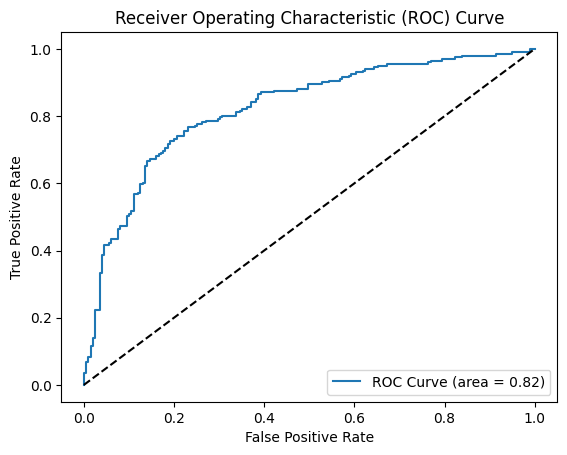

In [23]:
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd

# 定义逻辑回归模型和参数网格
model = LogisticRegression()
param_grid = {'C': [ 0.01, 0.1,1]}

# 使用GridSearchCV进行自动调参和5折交叉验证
grid_search_lr = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, Y_train)

# 打印最佳参数和最佳得分
print('Best Parameters:', grid_search_lr.best_params_)
print('Best Score:', grid_search_lr.best_score_)

# 在训练集上评估模型
Y_train_pred = grid_search_lr.predict(X_train)
print('Training Accuracy:', accuracy_score(Y_train, Y_train_pred))
print('Training Precision:', precision_score(Y_train, Y_train_pred))
print('Training Recall:', recall_score(Y_train, Y_train_pred))
print('Training F1 Score:', f1_score(Y_train, Y_train_pred))

# 在测试集上评估模型
Y_test_pred = grid_search_lr.predict(X_test)
print('Testing Accuracy:', accuracy_score(Y_test, Y_test_pred))
print('Testing Precision:', precision_score(Y_test, Y_test_pred))
print('Testing Recall:', recall_score, Y_test_pred)
print('Testing F1 Score:', f1_score(Y_test, Y_test_pred))

# 绘制ROC曲线和计算AUC
fpr, tpr, thresholds = roc_curve(Y_test, grid_search_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

比较三个代表性模型的性能，如果相差很大，那就不用再加RF, SVM,如果相差不大，加上。
多个模型和多个可解释性的比较分析，用预测正确的结果进行可解释性分析。


In [24]:
# 将LR, XGB, NN的模型性能进行对比

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

# 训练三个机器学习模型并预测测试集
model_lr = grid_search_lr
model_xgb = grid_search_xgb
model_mlp = grid_search_mlp

Y_test_pred1 = model_lr.predict(X_test)
Y_test_pred2 = model_xgb.predict(X_test)
Y_test_pred3 = model_mlp.predict(X_test)
Y_test_pred4 = model_xgb2.predict(X_test)

# 计算评价指标
accuracy_train1 = accuracy_score(Y_train, model_lr.predict(X_train))
accuracy_train2 = accuracy_score(Y_train, model_xgb.predict(X_train))
accuracy_train3 = accuracy_score(Y_train, model_mlp.predict(X_train))
accuracy_train4 = accuracy_score(Y_train, model_xgb2.predict(X_train))

accuracy_test1 = accuracy_score(Y_test, model_lr.predict(X_test))
accuracy_test2 = accuracy_score(Y_test, model_xgb.predict(X_test))
accuracy_test3 = accuracy_score(Y_test, model_mlp.predict(X_test))
accuracy_test4 = accuracy_score(Y_test, model_xgb2.predict(X_test))

precision_train1 = precision_score(Y_train, model_lr.predict(X_train))
precision_train2 = precision_score(Y_train, model_xgb.predict(X_train))
precision_train3 = precision_score(Y_train, model_mlp.predict(X_train))
precision_train4 = precision_score(Y_train, model_xgb2.predict(X_train))

precision_test1 = precision_score(Y_test, Y_test_pred1)
precision_test2 = precision_score(Y_test, Y_test_pred2)
precision_test3 = precision_score(Y_test, Y_test_pred3)
precision_test4 = precision_score(Y_test, Y_test_pred4)

recall_train1 = recall_score(Y_train, model_lr.predict(X_train))
recall_train2 = recall_score(Y_train, model_xgb.predict(X_train))
recall_train3 = recall_score(Y_train, model_mlp.predict(X_train))
recall_train4 = recall_score(Y_train, model_xgb2.predict(X_train))

recall_test1 = recall_score(Y_test, Y_test_pred1)
recall_test2 = recall_score(Y_test, Y_test_pred2)
recall_test3 = recall_score(Y_test, Y_test_pred3)
recall_test4 = recall_score(Y_test, Y_test_pred4)

f1score_train1 = f1_score(Y_train, model_lr.predict(X_train))
f1score_train2 = f1_score(Y_train, model_xgb.predict(X_train))
f1score_train3 = f1_score(Y_train, model_mlp.predict(X_train))
f1score_train4 = f1_score(Y_train, model_xgb2.predict(X_train))

f1score_test1 = f1_score(Y_test, Y_test_pred1)
f1score_test2 = f1_score(Y_test, Y_test_pred2)
f1score_test3 = f1_score(Y_test, Y_test_pred3)
f1score_test4 = f1_score(Y_test, Y_test_pred4)

# 将评价指标存储在字典中
results_train = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp', 'Model_xgb2'],
    'Accuracy (train)': [accuracy_train1, accuracy_train2, accuracy_train3, accuracy_train4],
    'Precision (train)': [precision_train1, precision_train2, precision_train3, precision_train4],
    'Recall (train)': [recall_train1, recall_train2, recall_train3, recall_train4],
    'F1 score (train)': [f1score_train1, f1score_train2, f1score_train3, f1score_train4],
}
results_test = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp', 'Model_xgb2'],
    'Accuracy (test)': [accuracy_test1, accuracy_test2, accuracy_test3, accuracy_test4],
    'Precision (test)': [precision_test1, precision_test2, precision_test3, precision_test4],
    'Recall (test)': [recall_test1, recall_test2, recall_test3, recall_test4],
    'F1 score (test)': [f1score_test1, f1score_test2, f1score_test3, f1score_test4],
}
# 将字典转换为 Pandas 数据框
df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)

# 打印结果
print(df_results_train)
print(df_results_test)

        Model  Accuracy (train)  Precision (train)  Recall (train)   
0    Model_lr          0.776875           0.790026        0.753442  \
1   Model_xgb          0.901250           0.909323        0.891114   
2   Model_mlp          0.805000           0.807838        0.799750   
3  Model_xgb2          0.845625           0.854756        0.832290   

   F1 score (train)  
0          0.771300  
1          0.900126  
2          0.803774  
3          0.843373  
        Model  Accuracy (test)  Precision (test)  Recall (test)   
0    Model_lr           0.7650          0.786096       0.731343  \
1   Model_xgb           0.7800          0.786802       0.771144   
2   Model_mlp           0.7575          0.770833       0.736318   
3  Model_xgb2           0.7600          0.769231       0.746269   

   F1 score (test)  
0         0.757732  
1         0.778894  
2         0.753181  
3         0.757576  


In [25]:
df_results_train

,Model,Accuracy (train),Precision (train),Recall (train),F1 score (train)
0,Model_lr,0.776875,0.790026,0.753442,0.771300
1,Model_xgb,0.901250,0.909323,0.891114,0.900126
2,Model_mlp,0.805000,0.807838,0.799750,0.803774
3,Model_xgb2,0.845625,0.854756,0.832290,0.843373


In [26]:
df_results_test

,Model,Accuracy (test),Precision (test),Recall (test),F1 score (test)
0,Model_lr,0.7650,0.786096,0.731343,0.757732
1,Model_xgb,0.7800,0.786802,0.771144,0.778894
2,Model_mlp,0.7575,0.770833,0.736318,0.753181
3,Model_xgb2,0.7600,0.769231,0.746269,0.757576


xgb_loss 0.5219666182857353
linear_loss 0.5343686615659443
dnn_loss 8.740585946860909

xgb_roc_auc 0.8347958698967473
linear_roc_auc 0.8210455261381534
dnn_roc_auc 0.757606440161004

xgb_pr_auc 0.8399990497379285
linear_pr_auc 0.8132206150537289
dnn_pr_auc 0.7000787728026534



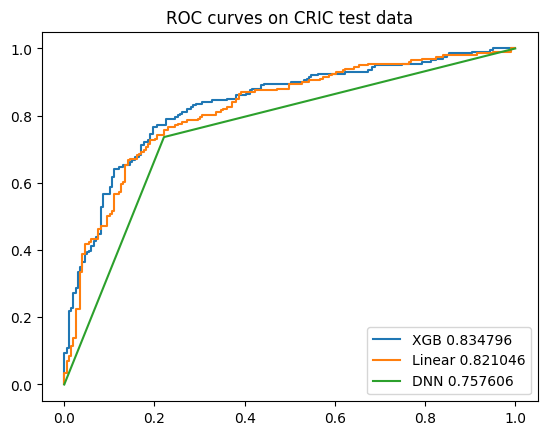

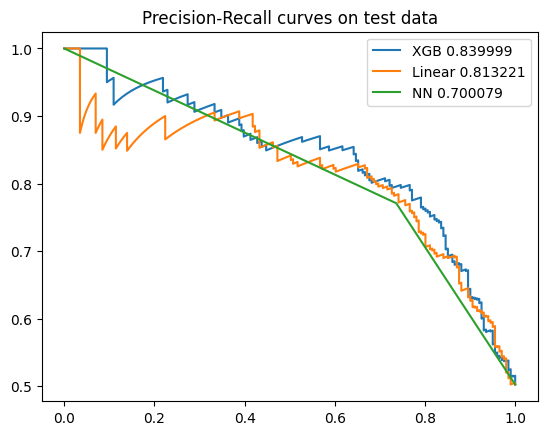

In [27]:
# Compute performance metrics
Y_test1 = Y_test.ravel() # 将Y_test1转换为一维数组
xgb_loss = sklearn.metrics.log_loss(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(Y_test1, model_lr.predict_proba(X_test)[:,1])
nn_loss = sklearn.metrics.log_loss(Y_test1, model_mlp.predict(X_test))
# constant_loss = sklearn.metrics.log_loss(Y_test1, np.zeros(len(Y_test1)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", nn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_mlp.predict(X_test))
#svm_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
#print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_mlp.predict(X_test))
#svm_pr_auc = sklearn.metrics.average_precision_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
#print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_mlp.predict(X_test))
#svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, svm_model.predict_proba(X_test))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
#pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_mlp.predict(X_test))
#svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, svm_model.predict_proba(X_test))

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="NN %f" % dnn_pr_auc)
#pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on test data")
pl.show()

### 将三个模型预测准确的样本选出来分别放入一个样本集中，用于后续可解释性方法对比分析
1. 用训练好的模型预测剩余样本
2. 将所有样本（训练集、测试集、预测集）预测概率与是否预测正确输出，并于样本编号匹配
3. 挑选出预测正确的样本
4. 用不同可解释性方法对不同模型预测正确的样本进行可解释性分析

In [28]:
X_train_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,1141,0.999397,0.173399,0.549546,72.226001,1.713131,37.862375,5.608351
6313,6505,1.052287,0.177812,0.572182,12.994616,1.659102,119.293873,5.895469
9241,9484,0.995182,0.172525,0.566395,572.007472,2.398591,1459.570160,6.854123
1667,1703,1.037544,0.171817,0.538856,969.967265,3.287239,1702.763051,5.527596
10790,11085,1.022866,0.168181,0.562099,298.789534,3.515222,602.339686,5.146189
...,...,...,...,...,...,...,...,...
15382,15902,1.076437,0.172001,0.608034,589.605970,2.332164,2145.447255,5.568414
9477,9725,0.938162,0.160481,0.547768,488.924547,2.286274,1140.057086,5.968980
10924,11223,0.997026,0.167253,0.567125,484.307499,1.816500,1770.216193,7.045041
16820,17450,1.058375,0.165438,0.563715,836.129477,3.463896,1106.503700,6.558235


In [29]:
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,-0.198345,0.815532,-0.563179,-1.207226,-0.904915,-1.298449,-0.296577
6313,0.814773,1.475330,0.661020,-1.351593,-0.959857,-1.197270,-0.081835
9241,-0.279089,0.684847,0.348033,0.010909,-0.207871,0.468036,0.635163
1667,0.532382,0.579010,-1.141304,0.980870,0.695795,0.770206,-0.356975
10790,0.251212,0.035259,0.115690,-0.655015,0.927632,-0.597081,-0.642237
...,...,...,...,...,...,...,...
15382,1.277385,0.606426,2.599901,0.053802,-0.275421,1.320245,-0.326446
9477,-1.371322,-1.115988,-0.659312,-0.191592,-0.322086,0.071038,-0.026854
10924,-0.243759,-0.103398,0.387507,-0.202845,-0.799799,0.854017,0.777954
16820,0.931407,-0.374830,0.203125,0.654663,0.875438,0.029348,0.413862


In [30]:
df2

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
7,7,1.030442,0.173909,0.541106,1389.506261,3.703773,1914.187620,5.250920,0
10,10,1.052772,0.174059,0.537689,1456.337635,3.918565,2524.349979,5.334451,1
11,11,1.052868,0.174058,0.537678,1459.758586,3.986615,2520.808509,4.588114,0
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [31]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.432630,0.890960,-1.038326,2.028556,0.860956,1.179620,1.126717
3,0.580180,0.893061,-1.109806,2.243038,0.901934,1.464602,2.102643
7,0.396328,0.891687,-1.019603,2.003427,1.119368,1.032903,-0.563906
10,0.824065,0.914127,-1.204403,2.166318,1.337791,1.791035,-0.501432
11,0.825910,0.914094,-1.204995,2.174656,1.406990,1.786635,-1.059634
...,...,...,...,...,...,...,...
16863,-0.702539,0.875810,-0.095450,-0.679580,-0.133438,-0.108165,-0.343891
16864,-0.719087,0.870297,-0.100513,-0.647444,-0.029992,-0.072902,1.062009
16865,-0.667005,0.883984,-0.079468,-0.791647,-0.460202,-0.239412,0.476518
16866,-0.636365,0.889980,-0.064066,-0.836215,-0.440026,-0.368419,0.231358


In [32]:
X_train_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1119,1141,0.999397,0.173399,0.549546,72.226001,1.713131,37.862375,5.608351
6313,6505,1.052287,0.177812,0.572182,12.994616,1.659102,119.293873,5.895469
9241,9484,0.995182,0.172525,0.566395,572.007472,2.398591,1459.570160,6.854123
1667,1703,1.037544,0.171817,0.538856,969.967265,3.287239,1702.763051,5.527596
10790,11085,1.022866,0.168181,0.562099,298.789534,3.515222,602.339686,5.146189
...,...,...,...,...,...,...,...,...
15382,15902,1.076437,0.172001,0.608034,589.605970,2.332164,2145.447255,5.568414
9477,9725,0.938162,0.160481,0.547768,488.924547,2.286274,1140.057086,5.968980
10924,11223,0.997026,0.167253,0.567125,484.307499,1.816500,1770.216193,7.045041
16820,17450,1.058375,0.165438,0.563715,836.129477,3.463896,1106.503700,6.558235


In [33]:
X_test_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
10718,11009,0.996175,0.169461,0.567291,1081.303508,1.594754,1853.027594,7.901773
2272,2326,0.929733,0.176446,0.559289,61.542719,2.806802,309.195648,4.509469
13486,13899,1.077548,0.168403,0.585082,583.458349,1.076117,1281.827877,6.886266
731,744,0.995944,0.174152,0.548294,563.397028,2.658946,334.443685,7.168049
16110,16666,1.054811,0.158428,0.565912,1029.100554,3.583829,577.907770,3.823400
...,...,...,...,...,...,...,...,...
5700,5876,0.921578,0.153267,0.532311,616.389836,2.632999,891.602472,5.587851
9083,9326,0.929874,0.159478,0.544341,1047.378444,1.854682,736.727137,7.320218
2666,2736,1.015290,0.170738,0.548509,449.606549,2.962050,610.301710,6.399009
12689,13065,1.065283,0.168223,0.583795,124.899475,1.880087,501.718730,4.848964


In [34]:
df2

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
7,7,1.030442,0.173909,0.541106,1389.506261,3.703773,1914.187620,5.250920,0
10,10,1.052772,0.174059,0.537689,1456.337635,3.918565,2524.349979,5.334451,1
11,11,1.052868,0.174058,0.537678,1459.758586,3.986615,2520.808509,4.588114,0
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [35]:
# 将训练、测试、预测结果与输入一起保存到output文件中
# 训练集
output_train_lr = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_lr.predict_proba(X_train)[:,1], index=X_train_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
outpt_train_xgb = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_xgb.predict_proba(X_train)[:,1], index=X_train_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_train_mlp = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_mlp.predict_proba(X_train)[:,1], index=X_train_orgin.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 测试集
output_test_lr = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_lr.predict_proba(X_test)[:,1], index=X_test_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_xgb = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_xgb.predict_proba(X_test)[:,1], index=X_test_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_mlp = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_mlp.predict_proba(X_test)[:,1], index=X_test_orgin.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 预测集
output_pred_lr = pd.concat([df2, pd.Series(model_lr.predict_proba(X_pred)[:,1], index=df2.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_xgb = pd.concat([df2, pd.Series(model_xgb.predict_proba(X_pred)[:,1], index=df2.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_mlp = pd.concat([df2, pd.Series(model_mlp.predict_proba(X_pred)[:,1], index=df2.index, name='probability_1')], axis=1) # 保留预测为1的概率


# predicted列为预测结果，0为未被淹，1为被淹
# 训练集
output_train_lr['predicted'] = (output_train_lr['probability_1'] >= 0.5).astype(int)
outpt_train_xgb['predicted'] = (outpt_train_xgb['probability_1'] >= 0.5).astype(int)
output_train_mlp['predicted'] = (output_train_mlp['probability_1'] >= 0.5).astype(int)

# 测试集
output_test_lr['predicted'] = (output_test_lr['probability_1'] >= 0.5).astype(int)
output_test_xgb['predicted'] = (output_test_xgb['probability_1'] >= 0.5).astype(int)
output_test_mlp['predicted'] = (output_test_mlp['probability_1'] >= 0.5).astype(int)

# 预测集
output_pred_lr['predicted'] = (output_pred_lr['probability_1'] >= 0.5).astype(int)
output_pred_xgb['predicted'] = (output_pred_xgb['probability_1'] >= 0.5).astype(int)
output_pred_mlp['predicted'] = (output_pred_mlp['probability_1'] >= 0.5).astype(int)


# 判断预测是否正确
# 训练集
output_train_lr['correct'] = (output_train_lr['predicted'] == output_train_lr['label']).astype(int)
outpt_train_xgb['correct'] = (outpt_train_xgb['predicted'] == outpt_train_xgb['label']).astype(int)
output_train_mlp['correct'] = (output_train_mlp['predicted'] == output_train_mlp['label']).astype(int)

# 测试集
output_test_lr['correct'] = (output_test_lr['predicted'] == output_test_lr['label']).astype(int)
output_test_xgb['correct'] = (output_test_xgb['predicted'] == output_test_xgb['label']).astype(int)
output_test_mlp['correct'] = (output_test_mlp['predicted'] == output_test_mlp['label']).astype(int)

# 预测集
output_pred_lr['correct'] = (output_pred_lr['predicted'] == output_pred_lr['label']).astype(int)
output_pred_xgb['correct'] = (output_pred_xgb['predicted'] == output_pred_xgb['label']).astype(int)
output_pred_mlp['correct'] = (output_pred_mlp['predicted'] == output_pred_mlp['label']).astype(int)

# 将预测正确的样本保存在output文件中
# 训练集
output_train_lr_correct = output_train_lr[output_train_lr['correct'] == 1]
outpt_train_xgb_correct = outpt_train_xgb[outpt_train_xgb['correct'] == 1]
output_train_mlp_correct = output_train_mlp[output_train_mlp['correct'] == 1]

# 测试集
output_test_lr_correct = output_test_lr[output_test_lr['correct'] == 1]
output_test_xgb_correct = output_test_xgb[output_test_xgb['correct'] == 1]
output_test_mlp_correct = output_test_mlp[output_test_mlp['correct'] == 1]

# 预测集
output_pred_lr_correct = output_pred_lr[output_pred_lr['correct'] == 1]
output_pred_xgb_correct = output_pred_xgb[output_pred_xgb['correct'] == 1]
output_pred_mlp_correct = output_pred_mlp[output_pred_mlp['correct'] == 1]

# 保存到CSV文件中
# 测试集
output_train_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_lr_correct.csv', index=False)
outpt_train_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_xgb_correct.csv', index=False)
output_train_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_mlp_correct.csv', index=False)

# 测试集
output_test_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_lr_correct.csv', index=False)
output_test_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_xgb_correct.csv', index=False)
output_test_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_mlp_correct.csv', index=False)

# 预测集
output_pred_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_mlp_correct.csv', index=False)

# 将测试集、训练集、预测集结果预测正确的样本保存在一个文件中
output_pred_lr_correct_all = pd.concat([output_train_lr_correct, output_test_lr_correct, output_pred_lr_correct], axis=0)
output_pred_xgb_correct_all = pd.concat([outpt_train_xgb_correct, output_test_xgb_correct, output_pred_xgb_correct], axis=0)
output_pred_mlp_correct_all = pd.concat([output_train_mlp_correct, output_test_mlp_correct, output_pred_mlp_correct], axis=0)

# 保存到CSV文件中
output_pred_lr_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_mlp_correct.csv', index=False)




In [36]:
# TREESHAP

# 初始化SHAP解释器并计算特征重要性
explainer = shap.Explainer(model_xgb2.predict_proba, X_train)
shap_values = explainer(all_features)

# 绘制汇总图表显示每个特征的重要性
shap.summary_plot(shap_values, all_features)

# 指标1 runtime 解释1000个预测样本所需的时间

# 指标2 local accuracy 1000个样本中，与模型输出的差异的归一化标准偏差

# 指标3 Consistency guarantees 一致性保证是解释方法的一个理论属性，它确保成对的案例永远一致（属性2）。我们把对这一属性的同意分成三个不同的类别：确切的保证、在无限抽样情况下成立的保证和没有保证。

# 指标4 Keep positive (mask) 指标衡量的是解释方法找到使模型输出增加最多的特征的能力。增加模型输出最多的特征。对于一个单一的输入，最积极的输入特征被保留在它们的原始值上，而所有其他的输入特征被掩盖在它们的平均值上。
# github库 Captum


In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# KernelSHAP

In [ ]:
# Individual Conditional Expectation (ICE) https://github.com/AustinRochford/PyCEbox

In [ ]:
# Counterfactual Explanations https://github.com/interpretml/DiCE

In [ ]:
# LIME GitHub代码找到 https://github.com/marcotcr/lime

In [ ]:
# saabas可以加上,nmL那篇文章都加了，我们也可以加，https://github.com/andosa/treeinterpreter


In [37]:
# 加载数据集
dtrain = xgboost.DMatrix(X_train, label=Y_train)

# 训练XGBoost模型
params = {
    "eta": 0.01,
    "objective": "reg:squarederror",
    "max_depth": 4,
    "subsample": 0.5,
    "colsample_bytree": 0.5
}
model = xgboost.train(params, dtrain, num_boost_round=100)

# 使用SHAP解释模型
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# 绘制SHAP摘要图
shap.summary_plot(shap_values, X_train)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <xgboost.core.Booster object at 0x7f6f8fad1030>